In [314]:
from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.io import read
#from ase.build import mx2
from ase.build import graphene

from abtem import *
from abtem.structures import orthogonalize_cell

current version: 1.0.0beta32


In [315]:
%matplotlib inline

In [330]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (10, 4)
matplotlib.rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

# STEM simulation of MoS$_2$

We build an atomic structure of MoS2 with ASE. Since abTEM requires an orthogonal we make the cell orthogonal. We also need to repeat the structure, so the probe fits inside the cell.

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

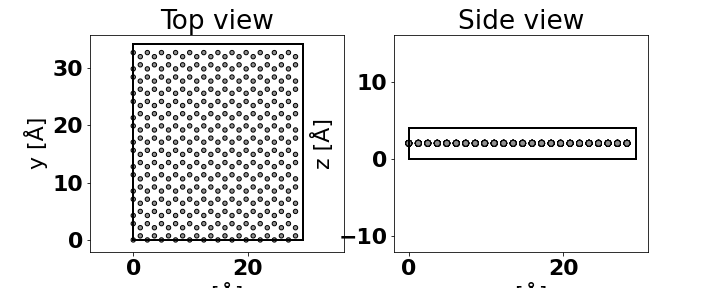

In [317]:
%matplotlib widget

gra = graphene(vacuum=2)

repetitions = (4, 4, 1)

atoms = orthogonalize_cell(gra) 

atoms *= (3,2,1)

show_atoms(atoms)

atoms *= repetitions 

atoms.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2)

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [63]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([29.52, 34.086759892955506, 4.0])


We create and calculate the electrostatic potential.

In [64]:
potential = Potential(atoms, 
                      gpts=512,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland')

potential = potential.build()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7efab414f790>)

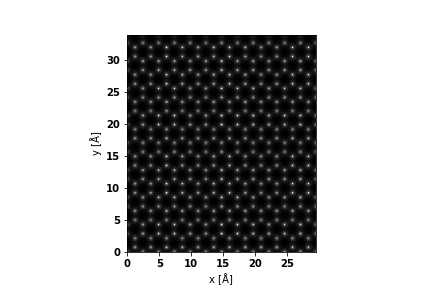

In [65]:
potential.project().show()

To simulate temperature effects uncomment the code below.

In [66]:
#sigmas = {'Mo': .1, 'S': .1} # standard deviations of thermal vibrations
#num_configs = 30 # number of frozen phonon configurations

#frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)
#potential = Potential(frozen_phonons, gpts=512, slice_thickness=1, parametrization='kirkland', projection='infinite')

In [67]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.05765625, 0.06657570291592872)


We create a probe with a semi-angle cutoff of 20 mrad.

In [147]:
energy = 100e3

In [381]:
probe = Probe(energy=energy, semiangle_cutoff=30, rolloff=0.1, defocus=0*40, Cs=0*3e5, focal_spread=0,device="cpu")

To run this simulation using PRISM instead of the standard multislice algorithm, uncomment the cell below. Note that while PRISM may be up to a 1000 times faster than multislice for large structures, the performance is fairly similar for small simulations like this.

In [382]:
#probe = SMatrix(energy=energy, semiangle_cutoff=20, expansion_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5)

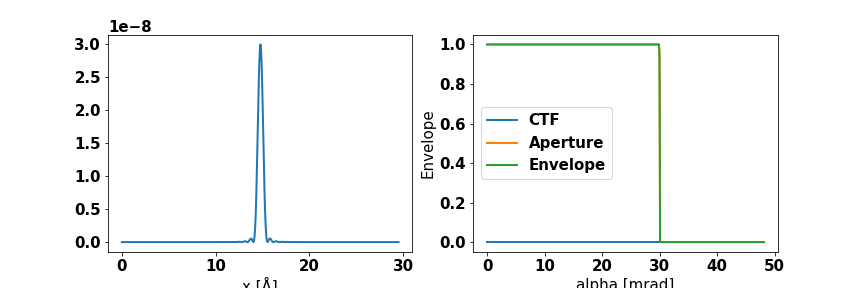

In [383]:
probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

probe.profile().show(ax=ax1);

probe.ctf.show(ax=ax2);

We create a `FlexibleAnnularDetector` detector which will allow us to choose the integration limits after the multislice simulation.

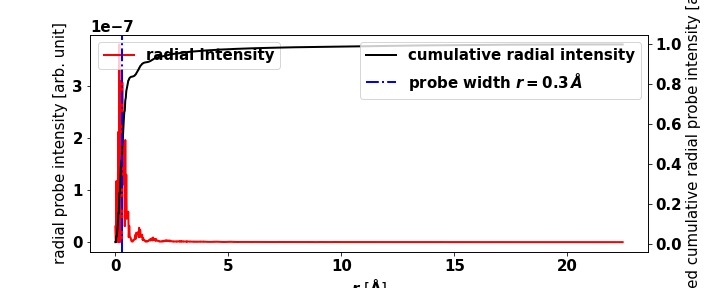

In [384]:
from abtem.utils import fft_shift
im=(np.absolute(fft_shift(probe.build().intensity().array,np.array([0,0]))))

calibration = probe.profile().calibrations[0]

center_indeces=np.unravel_index(im.argmax(),im.shape)
y,x = np.indices((im.shape)) # x and y are in pixels
r = np.sqrt((x-center_indeces[0])**2+(y-center_indeces[1])**2)    

# radius of the image.
r_max = np.max(r)  

ring_brightness, radius_edges = np.histogram(r, weights=im, bins=int(probe.gpts[0]*2))
radius = (radius_edges[1:]+radius_edges[0:-1])/2

fig, ax1 = plt.subplots()  
plt.plot(radius*calibration.sampling, ring_brightness,"r",label="radial intensity")
plt.xlabel(r"$r$ [$\mathrm{\AA}$]")
plt.ylabel(r"radial probe intensity [arb. unit]")
ax1.legend(loc=2)

ax2=ax1.twinx()

cumulative_radial = np.cumsum(ring_brightness)/ring_brightness.sum() #relaying on the fact that sampling in position is equidistant
plt.plot(radius*calibration.sampling,cumulative_radial,"k",label="cumulative radial intensity")
plt.ylabel(r"normalised cumulative radial probe intensity [arb. unit]")
r_half=radius[np.argmin(np.abs(cumulative_radial-0.5))]*calibration.sampling #in A
plt.axvline(x=r_half,color="b",linestyle="-.",label="probe width $r = {:.1f}\,\AA$ ".format(r_half))
ax2.legend(loc=1)
plt.show()

In [385]:
detector = FlexibleAnnularDetector()

We scan over one periodic unit of the potential at slightly better than the Nyquist frequency of the probe contrast transfer function.

In [386]:
end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

sampling=probe.ctf.nyquist_sampling*0.5

gridscan = GridScan(start=[0, 0], end=end, sampling=sampling) #probe.ctf.nyquist_sampling * .9)

measurement = probe.scan(gridscan, detector, potential)

Scan:   0%|          | 0/2640 [00:00<?, ?it/s]

In [387]:
sampling

0.15422652479693222

The output from the simulation is a `Measurement` object. This wraps a numpy array with calibrations descibing each axis. 

In our case, the first two dimensions of the numpy array scan dimenstions and the last dimension are the bins of the detector.

In [388]:
measurement.array.shape

(48, 55, 184)

We reduce the measurement to an image by integrating over the detector dimension.

In [389]:
measurement.integrate(0, 20).array.shape

(48, 55)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7efa676ead30>)

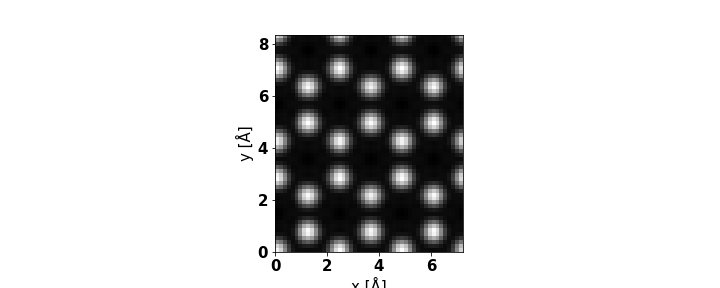

In [390]:
measurement.integrate(50, 150).show()

We can get a better view of the simulation output by tiling and interpolation the output.

In [391]:
bright_measurement = measurement.integrate(0, 20)
adf_measurement = measurement.integrate(50, 150)

tiled_bright_measurement = bright_measurement.tile((4,4))
tiled_adf_measurement = adf_measurement.tile((4,4))

#interp_bright_measurement = tiled_bright_measurement.interpolate(.05)
#interp_adf_measurement = tiled_adf_measurement.interpolate(.05)

#fig, (ax1, ax2) = plt.subplots(1, 2)

#interp_bright_measurement.show(ax=ax1)
#interp_adf_measurement.show(ax=ax2);

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7efa67872970>)

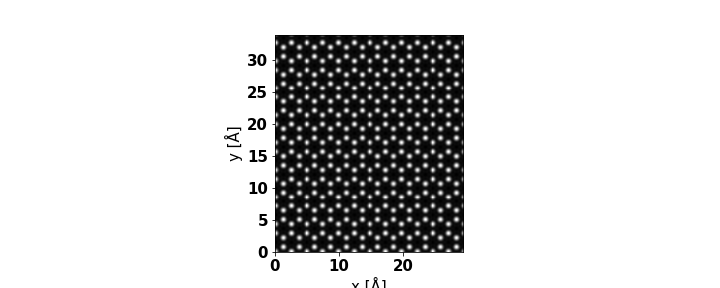

In [392]:
tiled_adf_measurement.show()

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7efa67587550>)

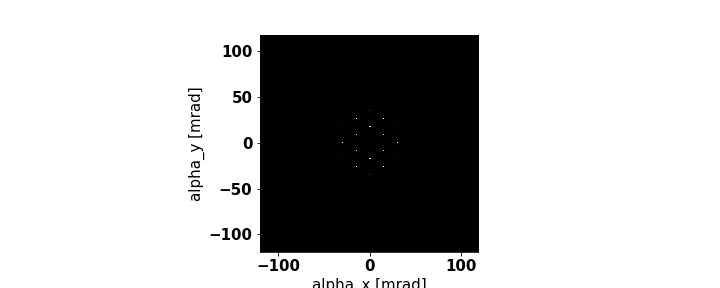

In [393]:
#%matplotlib widget
from abtem.measure import block_zeroth_order_spot
dd = tiled_adf_measurement.diffractograms(energy=energy)
dd_blocked = block_zeroth_order_spot(dd,1)
dd.show()

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7efa675ea1c0>)

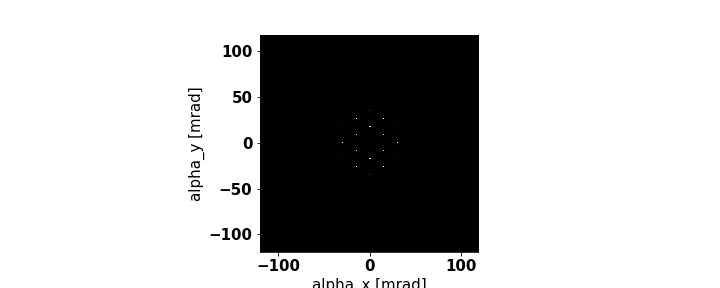

In [394]:
#%matplotlib widget
from abtem.measure import block_zeroth_order_spot
dd = tiled_adf_measurement.diffractograms(energy=energy)
dd_blocked = block_zeroth_order_spot(dd,1)
dd.show()

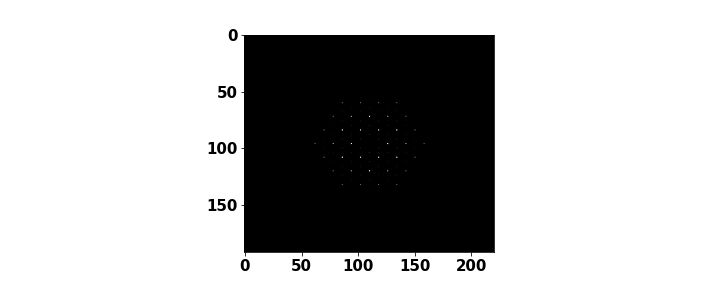

In [395]:
plt.figure()
plt.imshow(dd.array**0.25,cmap="gray")

In [396]:
alpha=17.2e-3

In [397]:
probe.wavelength/alpha

2.1519980204223104

In [398]:
r_half

0.3179306631434484

In [411]:
furthest_spot_alpha = np.array([17.2,30.48])*1e-3 # in rad #corresponding aperture semiangles are 10 mrad and 30 mrad
characteristic_length = probe.wavelength/furthest_spot_alpha #Angstrom
d50 = np.array([0.998,0.318]) # In angstrom

In [417]:
(characteristic_length[0]-characteristic_length[1])/(d50[0]-d50[1])

1.3788469638339647

In [416]:
characteristic_length

array([2.15199802, 1.21438209])